In [1]:
# pip install torchsummary

In [2]:
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from PIL import ImageOps, Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
from torchsummary import summary

In [3]:
# Paths to the dataset
train_path = '/kaggle/input/casting-512-512/Casting_512_512/train'
test_path = '/kaggle/input/casting-512-512/Casting_512_512/test'

In [4]:
class customCNN_69(nn.Module):
    def __init__(self, num_classes):
        super(customCNN_69, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [5]:
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: ImageOps.equalize(img, mask=None)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
# Load the datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transformations)
test_dataset = datasets.ImageFolder(root=test_path, transform=transformations)

In [7]:
# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [8]:
# Instantiate the model
num_classes = len(train_dataset.classes)
model = customCNN_69(num_classes)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]          73,856
             ReLU-11          [-1, 128, 28, 28]               0
        MaxPool2d-12          [-1, 128, 14, 14]               0
           Linear-13                  [-1, 512]      12,845,568
             ReLU-14                  [

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

In [12]:
patience = 7
best_val_loss = float('inf')
counter = 0

num_epochs = 40

In [13]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate training loss and accuracy for this epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100
    
    # Append to history
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

        # Calculate validation loss and accuracy
        val_loss = val_running_loss / len(test_loader)
        val_accuracy = 100 * val_correct / val_total
        
        # Append to history
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print("Best Model Save")
        model.train()
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}.')
            break

# After training, load the best model
state_dict = torch.load('best_model.pt',weights_only=False, map_location=device)
model.load_state_dict(state_dict)
print("Best Model Loaded")

Epoch 1/40, Train Loss: 0.6740, Train Accuracy: 60.06%
Validation Loss: 0.6802, Validation Accuracy: 60.15%
Best Model Save
Epoch 2/40, Train Loss: 0.6209, Train Accuracy: 60.73%
Validation Loss: 0.5991, Validation Accuracy: 70.50%
Best Model Save
Epoch 3/40, Train Loss: 0.5165, Train Accuracy: 76.13%
Validation Loss: 0.5826, Validation Accuracy: 73.95%
Best Model Save
Epoch 4/40, Train Loss: 0.4974, Train Accuracy: 77.00%
Validation Loss: 0.5481, Validation Accuracy: 75.86%
Best Model Save
Epoch 5/40, Train Loss: 0.4694, Train Accuracy: 78.83%
Validation Loss: 0.5167, Validation Accuracy: 76.25%
Best Model Save
Epoch 6/40, Train Loss: 0.4377, Train Accuracy: 79.88%
Validation Loss: 0.4744, Validation Accuracy: 79.31%
Best Model Save
Epoch 7/40, Train Loss: 0.3894, Train Accuracy: 81.52%
Validation Loss: 0.4157, Validation Accuracy: 79.69%
Best Model Save
Epoch 8/40, Train Loss: 0.3441, Train Accuracy: 83.45%
Validation Loss: 0.3453, Validation Accuracy: 82.76%
Best Model Save
Epoch 9/

In [14]:
# Test phase (final evaluation)
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100. * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 98.08%


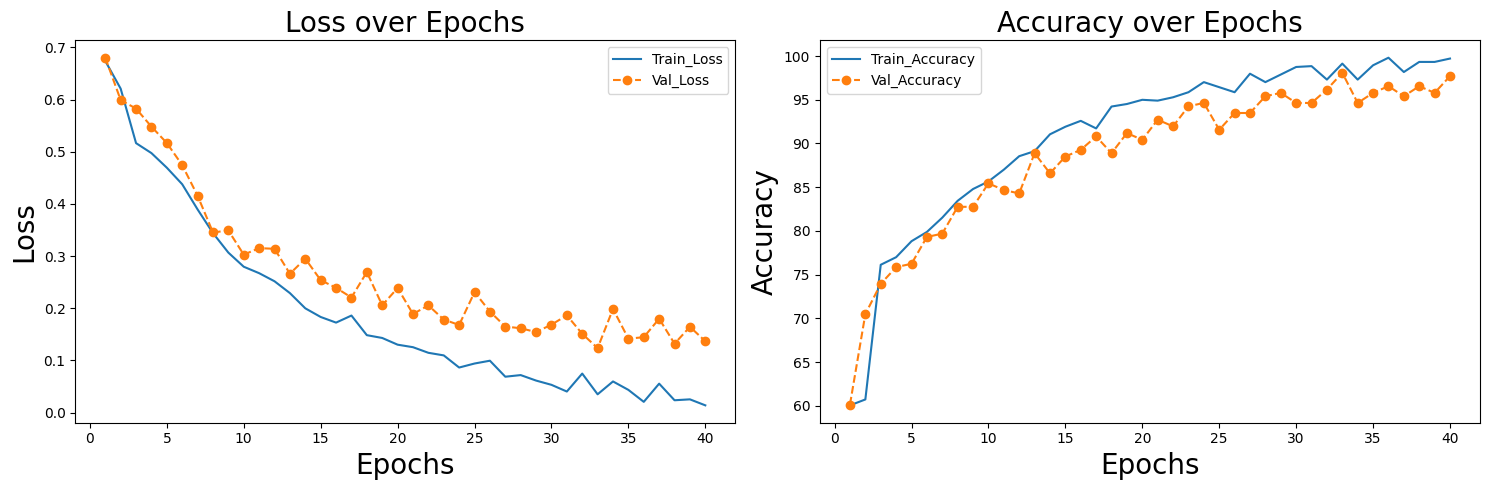

In [15]:
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train_Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Val_Loss', linestyle='--', marker='o')
plt.title('Loss over Epochs',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train_Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_history, label='Val_Accuracy', linestyle='--', marker='o')
plt.title('Accuracy over Epochs',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.legend()

plt.tight_layout()
plt.savefig('Loss and Accuracy.png', dpi=300)
plt.show()

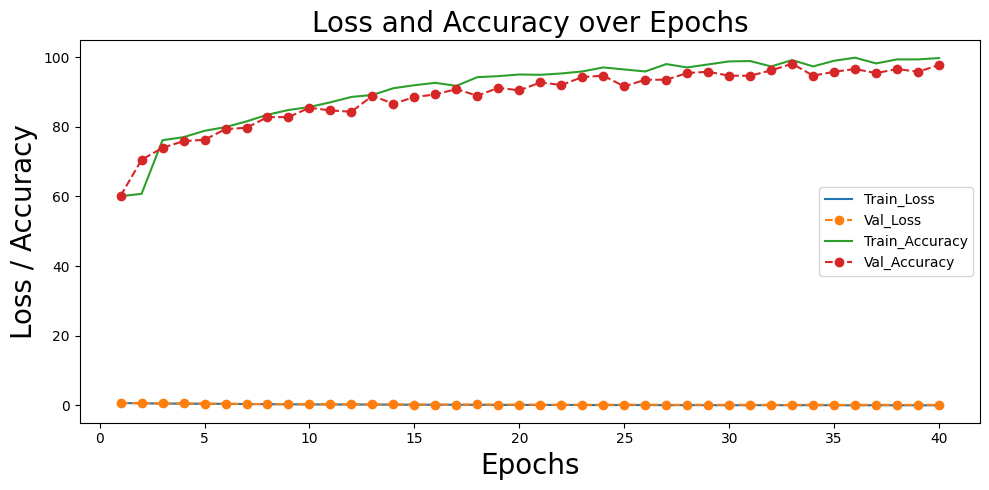

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Loss plot
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train_Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Val_Loss', linestyle='--', marker='o')

# Accuracy plot
plt.plot(range(1, num_epochs + 1), [acc for acc in train_accuracy_history], label='Train_Accuracy')
plt.plot(range(1, num_epochs + 1), [acc for acc in val_accuracy_history], label='Val_Accuracy', linestyle='--', marker='o')

plt.title('Loss and Accuracy over Epochs',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss / Accuracy',fontsize=20)
plt.legend()

plt.tight_layout()
plt.savefig('Loss and AccuracySingle.png', dpi=300)
plt.show()

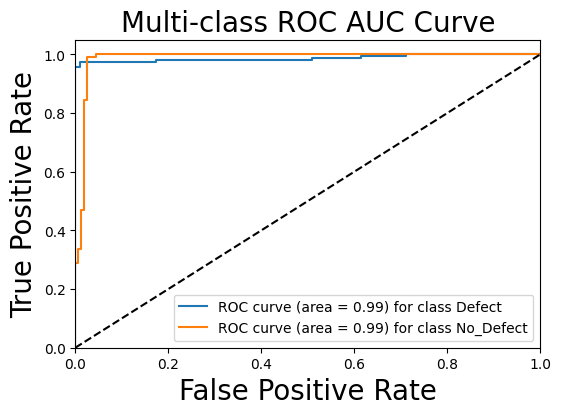

In [17]:
def plot_roc_curve(fpr, tpr, roc_auc, classes):
    plt.figure(figsize=(6, 4))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {classes[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.title('Multi-class ROC AUC Curve',fontsize=20)
    plt.legend(loc="lower right")
    plt.savefig('ROC_AUC.png', dpi=300)
    plt.show()

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(train_dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plot_roc_curve(fpr, tpr, roc_auc, train_dataset.classes)

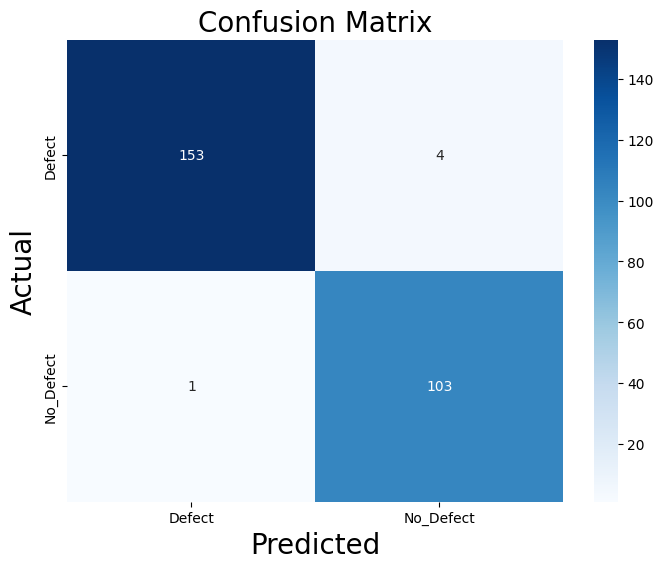

In [18]:
class_predictions = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, class_predictions)
labels = ['Defect', 'No_Defect']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix',fontsize=20)
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.savefig('ConfusionMatrix.png', dpi=300)
plt.show()

In [19]:
print(classification_report(y_true, class_predictions, target_names=train_dataset.classes))

              precision    recall  f1-score   support

      Defect       0.99      0.97      0.98       157
   No_Defect       0.96      0.99      0.98       104

    accuracy                           0.98       261
   macro avg       0.98      0.98      0.98       261
weighted avg       0.98      0.98      0.98       261



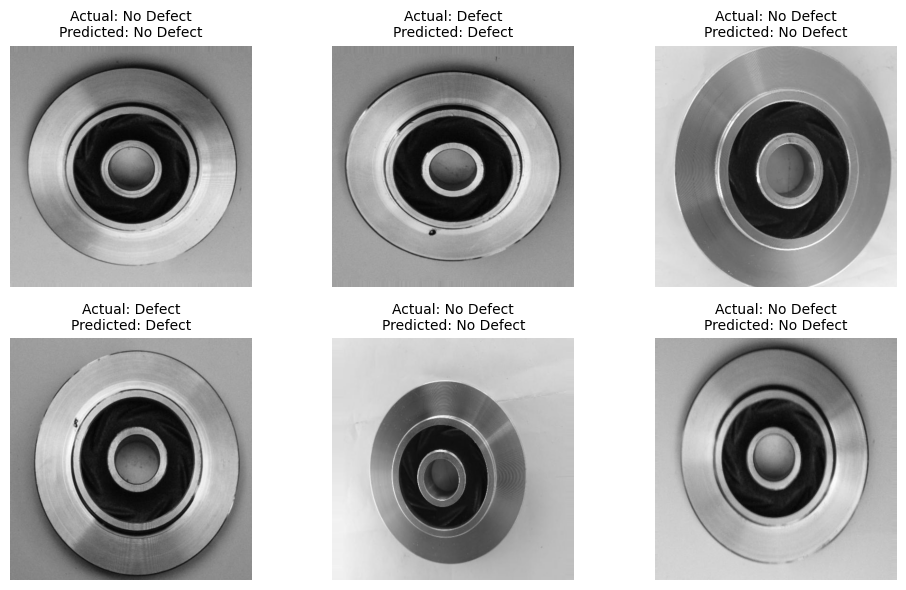

In [20]:
def get_predictions(model, dataloader):
    model.eval()
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs)
            all_predictions.append(predictions.cpu().numpy())
    
    return np.concatenate(all_predictions)

predictions = get_predictions(model, test_loader)

predictions_binary = (predictions[:, 0] > 0.5).astype(int)

true_labels = np.array(test_dataset.targets)

misclassified_indices = np.where(predictions_binary != true_labels)[0]



if len(misclassified_indices) >= 6:
    random_misclassified_indices = random.sample(list(misclassified_indices), 6)
else:
    random_misclassified_indices = random.sample(list(np.where(predictions_binary == true_labels)[0]), 6)

# Plot misclassified samples
plt.figure(figsize=(10, 6))

for i, index in enumerate(random_misclassified_indices):
    img_path = test_dataset.imgs[index][0]
    true_label = "Defect" if test_dataset.targets[index] == 0 else "No Defect"
    predicted_label = "No Defect" if predictions_binary[index] == 0 else "Defect"

    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Actual: {true_label}\nPredicted: {predicted_label}", fontsize=10)
    plt.axis('off')

# Save the misclassification image grid
plt.savefig('sample_classification.png', dpi=300)
plt.tight_layout()
plt.show()

In [21]:
torch.save(model.state_dict(), 'customCNN_69.pth')